In [24]:

import os
import pandas as pd
import numpy as np

from typing import Literal
from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (roc_curve, roc_auc_score, auc, 
                            precision_recall_curve, classification_report
                            )
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn import svm


In [25]:

#load data
DATA_FILEPATH = os.path.join(os.curdir, "data", "detect.csv")
data=pd.read_csv(DATA_FILEPATH)

# separate into train and test
x_train, x_test, y_train, y_test = train_test_split(data["text"], data["label"], 
                                                    test_size=0.3, 
                                                    random_state=0
                                                    )



In [26]:

def show_plots(x, y, curve_type: Literal["auc", "prc"], name, labels: tuple):
    
    plt.figure().set_figwidth(5)
    
    plt.plot(x, y, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])

    plt.title(f"{curve_type.upper()} of {name}")
    
    plt.show()

def create_model(x_train, y_train, x_test, y_test, min_df=1, stop_words=None,
                 print_result=True, algorithm_para=1.0):

    # initialize the TfidfVectorizer without any parameters
    vec = TfidfVectorizer(stop_words=stop_words, min_df=min_df)

    # choose classification model and add hyperparams
    model, model_name = svm.LinearSVC(C=algorithm_para), 'Linear SVM Model'

    # fit vectorizer using x_train and vectorize training data
    x_train = vec.fit_transform(x_train)
    x_test = vec.transform(x_test)
    # fit classifier model with training data
    model.fit(x_train, y_train)

    # predict test set output and get probability of guessing each class
    bin_preds = model.predict(x_test)
    pred_scores = model.decision_function(x_test)

    # get ROC curve using tpr/fpr and calculate AUC score
    fpr, tpr, _ = roc_curve(y_test, pred_scores)
    auc_score = roc_auc_score(y_test, pred_scores)

    # get PRC curve using precision/recall and calculate PRC score
    precision, recall, _ = precision_recall_curve(y_test, pred_scores)
    prc_score = auc(recall, precision)

    if print_result:
        # print curve scores
        print(f"AUC: {auc_score:.2%}\n",
            f'PRC: {prc_score:.2%}\n'
            )
        # print classification report
        print(classification_report(y_test, bin_preds, target_names=['0','1']))
        
        # plot AUC curve 
        show_plots(fpr, tpr,
                   "auc", model_name,
                   ("False Positive Rate", "True Positive Rate")
                )
        # plot PRC curve 
        show_plots(recall, precision,
                   "prc", model_name,
                   ("Recall", "Precision")
                )

    return auc_score, prc_score

def search_para(docs, y):

    # separate into train and test
    x_train, _, y_train, _ = train_test_split(docs, y, test_size=0.3, random_state=0)

    metric = 'f1_macro'
    # initialize search params
    params = {
    'tfidf__stop_words': [None, 'english'],
    'tfidf__min_df': [1, 2, 5],
    'clf__C': [0.1, 0.5, 1]
    }
    # create pipeline with vectorizer and classifier
    pipeline = pipeline = Pipeline([
                                     ("tfidf", TfidfVectorizer()),
                                     ("clf", svm.LinearSVC())
                                   ])

    grid = GridSearchCV(pipeline, param_grid=params, scoring =metric, cv=5, n_jobs=-1)
    # return optimal params
    return grid.fit(x_train, y_train)

# Show the impact of sample size
def sample_size_impact(docs, y):

    train_size = list(range(1,10))
    train_size.reverse()
    train_size = [i/10 for i in train_size]

    performance = []
    for size in train_size:
        print('Training sample size: ',(10-size*10)/10)
        # separate into train and test
        x_train, x_test, y_train, y_test = train_test_split(docs, y,  test_size=size, random_state=0)
        # calculate auc
        auc, _ = create_model(x_train, y_train, x_test, y_test, min_df=1,
                            stop_words='english', algorithm_para=1.0)

        performance.append(auc)

    plt.figure().set_figwidth(5)
    plt.axis((1, 0, 0.8, 1))
    plt.plot(train_size, performance, color='blue', lw=2, label='Model Performance')
    plt.xlabel('Testing Sample Percentage')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()


c:\Users\camer\AppData\Local\Programs\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


AUC: 96.89%
 PRC: 97.07%

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      2968
           1       0.92      0.89      0.91      3032

    accuracy                           0.91      6000
   macro avg       0.91      0.91      0.91      6000
weighted avg       0.91      0.91      0.91      6000



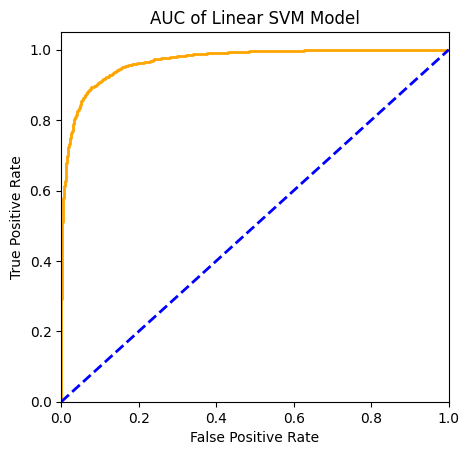

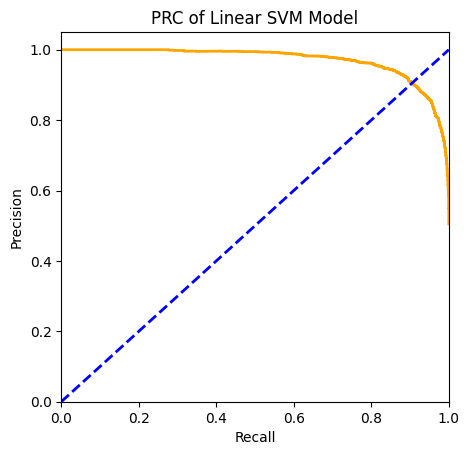

In [27]:

# default tokenizer
auc_score, prc_score = create_model(x_train, y_train, x_test, y_test, min_df=1, stop_words=None,
                                    print_result=True, algorithm_para=1.0)


c:\Users\camer\AppData\Local\Programs\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


AUC: 95.29%
 PRC: 95.67%

              precision    recall  f1-score   support

           0       0.86      0.91      0.88      2968
           1       0.90      0.85      0.88      3032

    accuracy                           0.88      6000
   macro avg       0.88      0.88      0.88      6000
weighted avg       0.88      0.88      0.88      6000



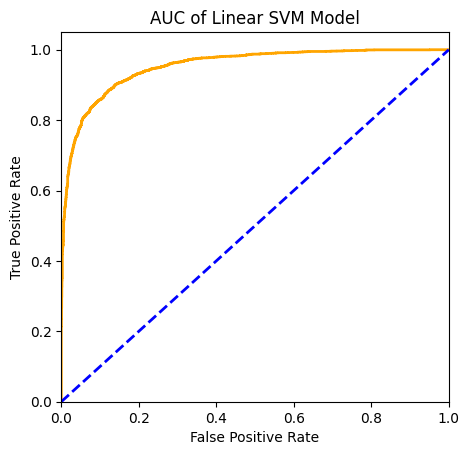

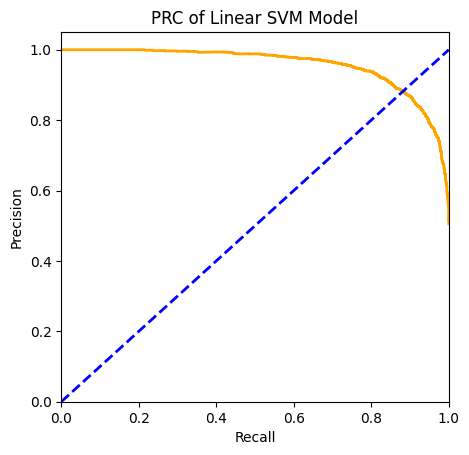

In [28]:
# custom tokenizer
auc_score, prc_score = create_model(x_train, y_train, x_test, y_test, min_df = 1, stop_words='english',
                                    print_result=True, algorithm_para=1.0)


c:\Users\camer\AppData\Local\Programs\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


clf__C:	0.5
tfidf__min_df:	5
tfidf__stop_words:	None
Best f1 score: 0.911


c:\Users\camer\AppData\Local\Programs\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


AUC: 97.25%
 PRC: 97.45%

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2968
           1       0.92      0.91      0.91      3032

    accuracy                           0.91      6000
   macro avg       0.91      0.91      0.91      6000
weighted avg       0.91      0.91      0.91      6000



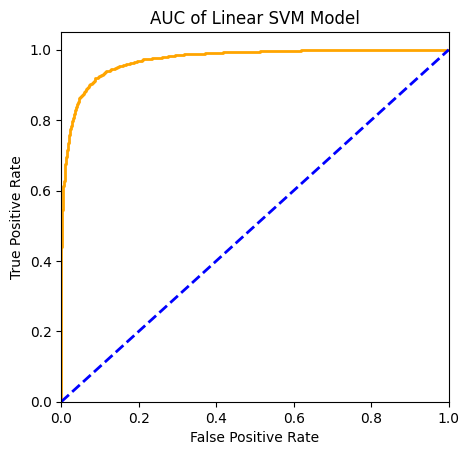

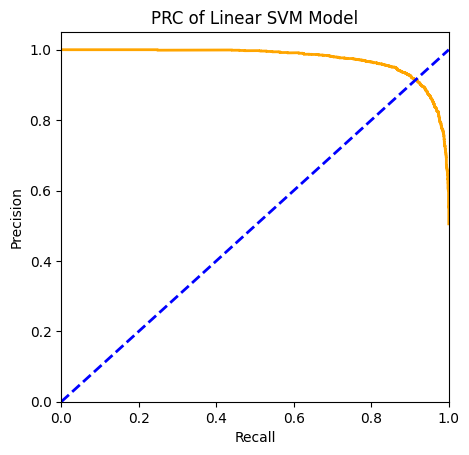

In [29]:

grid = search_para(data["text"], data["label"])

for param_name in grid.best_params_:
    print("{0}:\t{1}".format(param_name,grid.best_params_[param_name]))

print(f"Best f1 score: {grid.best_score_:.3f}")

min_df = grid.best_params_['tfidf__min_df']
stop_words = grid.best_params_['tfidf__stop_words']
C = grid.best_params_['clf__C']

auc_score, prc_score = create_model(x_train, y_train, x_test, y_test, min_df=min_df, stop_words=stop_words,
                                    print_result=True, algorithm_para=C)



c:\Users\camer\AppData\Local\Programs\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\camer\AppData\Local\Programs\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\camer\AppData\Local\Programs\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\camer\AppData\Local\Programs\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppres

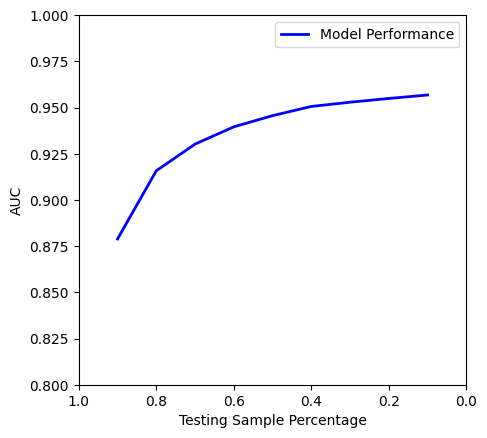

In [30]:

sample_size_impact(data["text"], data["label"])
